In [21]:
# Package imports
import numpy as np
from sklearn.model_selection import train_test_split

# Matplotlib is a matlab like plotting library
import matplotlib
from matplotlib import pyplot as plt
# SciKitLearn is a useful machine learning utilities library
import sklearn
# The sklearn dataset module helps generating |datasets
import sklearn.datasets
import sklearn.linear_model
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import normalize
from scipy.stats import gaussian_kde

In [22]:
# importing dataset
# import data
from DataExtraction import dataNoMass as data
from DataExtraction import dataWithP2
from DataExtraction import dataWithP2E2 
from DataExtraction import dataWithMass 
from DataExtraction import p2E2 
from DataExtraction import p2NegE2 
from DataExtraction import labels2D as labels
#from DataExtraction import labels
data = np.array(data)
labels = np.array(labels)
# labels = np.row_stack(labels)

In [23]:
# split data 
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, train_size=0.5, test_size=0.5, random_state=42)

In [24]:
# normalize test data
# train_data[:,0] = train_data[:,0] / np.linalg.norm(train_data[:,0]) # normalize column 0
# train_data[:,1] = train_data[:,1] / np.linalg.norm(train_data[:,1]) # normalize column 1
#normalize train data
# test_data[:,0] = test_data[:,0] / np.linalg.norm(test_data[:,0]) # normalize column 0
# test_data[:,1] = test_data[:,1] / np.linalg.norm(test_data[:,1]) # normalize column 1

In [25]:

avgE2 = np.mean(train_data)

In [26]:
train_data = train_data/avgE2
test_data = test_data/avgE2

In [27]:
# messing with the number of training data points
# train_data = train_data[0:9]
# train_labels = train_labels[0:9]

In [28]:
# Now we define all our functions

def softmax(z):
    #Calculate exponent term first
    exp_scores = np.exp(z)
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

# loss functions
def softmax_loss(y,y_hat):
    # Clipping value
    minval = 0.000000000001
    # Number of samples
    m = y.shape[0]
    # Loss formula, note that np.sum sums up the entire matrix and therefore does the job of two sums from the formula
    loss = -1/m * np.sum(y * np.log(y_hat.clip(min=minval)))
    #loss = -1/m * np.sum(y * np.log(y_hat))
    return loss

def crossEntropy_loss(y, y_hat):
    m = y.shape[0]
    if y.all() == 1:
        return -1/m * np.sum(np.log(y_hat))
    else:
        return -1/m * np.sum(np.log(1 - y_hat))

def mse_loss(y, y_hat):
    m = y.shape[0]
    return np.sum((y_hat - y)**2) / m
    
def loss_derivative(y,y_hat):
    return (y_hat-y)

def tanh_derivative(x):
    return (1 - np.power(x, 2))

# This is the forward propagation function
def forward_prop(model,a0):
    
    #Start Forward Propagation
    
    # Load parameters from model
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'],model['b3']
    
    # Do the first Linear step 
    # Z1 is the input layer x times the dot product of the weights + our bias b
    z1 = a0.dot(W1) + b1
    
    # Put it through the first activation function
    a1 = np.tanh(z1)
    
    # Second linear step
    z2 = a1.dot(W2) + b2
    
    # Second activation function
    a2 = np.tanh(z2)
    
    #Third linear step
    z3 = a2.dot(W3) + b3
    
    #For the Third linear activation function we use the softmax function, either the sigmoid of softmax should be used for the last layer
    a3 = softmax(z3)
    
    #Store all results in these values
    cache = {'a0':a0,'z1':z1,'a1':a1,'z2':z2,'a2':a2,'a3':a3,'z3':z3}
    return cache

# This is the BACKWARD PROPAGATION function
def backward_prop(model,cache,y):

    # Load parameters from model
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'],model['W3'],model['b3']
    # Load forward propagation results
    a0,a1, a2,a3 = cache['a0'],cache['a1'],cache['a2'],cache['a3']
    
    # Get number of samples
    m = y.shape[0]
    
    # Calculate loss derivative with respect to output
    dz3 = loss_derivative(y=y,y_hat=a3)

    # Calculate loss derivative with respect to second layer weights
    dW3 = 1/m*(a2.T).dot(dz3) #dW2 = 1/m*(a1.T).dot(dz2) 
    
    # Calculate loss derivative with respect to second layer bias
    db3 = 1/m*np.sum(dz3, axis=0)
    
    # Calculate loss derivative with respect to first layer
    dz2 = np.multiply(dz3.dot(W3.T) ,tanh_derivative(a2))
    
    # Calculate loss derivative with respect to first layer weights
    dW2 = 1/m*np.dot(a1.T, dz2)
    
    # Calculate loss derivative with respect to first layer bias
    db2 = 1/m*np.sum(dz2, axis=0)
    
    dz1 = np.multiply(dz2.dot(W2.T),tanh_derivative(a1))
    
    dW1 = 1/m*np.dot(a0.T,dz1)
    
    db1 = 1/m*np.sum(dz1,axis=0)
    
    # Store gradients
    grads = {'dW3':dW3, 'db3':db3, 'dW2':dW2,'db2':db2,'dW1':dW1,'db1':db1}
    return grads

#TRAINING PHASE
def initialize_parameters(input_dim,l1_dim, l2_dim, output_dim):
    # First layer weights
    W1 = 2 *np.random.randn(input_dim, l1_dim) - 1
    
    # First layer bias
    b1 = np.zeros((1, l1_dim))
    
    # Second layer weights
    W2 = 2 * np.random.randn(l1_dim, l2_dim) - 1
    
    # Second layer bias
    b2 = np.zeros((1, l2_dim))
    W3 = 2 * np.random.rand(l2_dim, output_dim) - 1
    b3 = np.zeros((1,output_dim))
    
    
    # Package and return model
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2,'W3':W3,'b3':b3}
    return model

def update_parameters(model,grads,learning_rate):
    # Load parameters
    W1, b1, W2, b2,b3,W3 = model['W1'], model['b1'], model['W2'], model['b2'],model['b3'],model["W3"]
    
    # Update parameters
    W1 -= learning_rate * grads['dW1']
    b1 -= learning_rate * grads['db1']
    W2 -= learning_rate * grads['dW2']
    b2 -= learning_rate * grads['db2']
    W3 -= learning_rate * grads['dW3']
    b3 -= learning_rate * grads['db3']
    
    # load parameters into running lists
    w00s.append(W1[0][0]) # modifies global list
    w01s.append(W1[0][1]) # modifies global list
    w02s.append(W1[0][2]) # modifies global list
    w03s.append(W1[0][3]) # modifies global list
    w04s.append(W1[0][4]) # modifies global list
    
    w10s.append(W1[1][0]) # modifies global list
    w11s.append(W1[1][1]) # modifies global list
    w12s.append(W1[1][2]) # modifies global list
    w13s.append(W1[1][3]) # modifies global list
    w14s.append(W1[1][4]) # modifies global list
    
    b0s.append(b1[0][0]) # modifies global list
    b1s.append(b1[0][1]) # modifies global list
    b2s.append(b1[0][2]) # modifies global list
    b3s.append(b1[0][3]) # modifies global list
    b4s.append(b1[0][4]) # modifies global list

    # Store and return parameters
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3':W3,'b3':b3}
    return model
def predict(model, x):
    # Do forward pass
    c = forward_prop(model,x)
    #get y_hat
    y_hat = c['a3']
    # plotArr.append([x, y_hat]) #added to make plot
    return y_hat
def calc_accuracy(model,x,y):
    # Get total number of examples
    m = y.shape[0]
    # Do a prediction with the model
    pred = predict(model,x)
    # Ensure prediction and truth vector y have the same shape
    pred = pred.reshape(y.shape)
    # Calculate the number of wrong examples
    error = np.sum(np.abs(pred-y))
    # Calculate accuracy
    return (m - error)/m * 100
def train(model,X_,y_,learning_rate, epochs=2001, print_loss=False):
    # Gradient descent. Loop over epochs
    for i in range(0, epochs):

        # Forward propagation
        cache = forward_prop(model,X_)
        #a1, probs = cache['a1'],cache['a2']
        # Backpropagation
        
        grads = backward_prop(model,cache,y_)
        # Gradient descent parameter update
        # Assign new parameters to the model
        model = update_parameters(model=model,grads=grads,learning_rate=learning_rate)
        # it is at this point in the training that the weights get added to the lists
    
        a3 = cache['a3']
        thisLoss = mse_loss(y_,a3) # set loss function here
        losses.append(thisLoss) # modifies global list
        y_hat = predict(model,X_) # getting rid of this because it's wrong
        y_true = y_.argmax(axis=1)
        accur = accuracy_score(a3,train_labels)
        train_accuracies.append(accur) # modifies global list
        
        if i % 50 == 0:
            placeholderVar = accuracy_score(a3, train_labels)
            test_accuracy = accuracyOfModel(model, test_data, test_labels)
            test_accuracies.append(test_accuracy) # modifies global list
            test_num.append(i)
        #Printing loss & accuracy every 100 iterations
        if print_loss and i % 300==0:
            print('Loss after iteration',i,':',thisLoss)
            print('Train Accuracy after iteration',i,':',accur*100,'%')
            print('Test Accuracy after iteration',i,':',test_accuracy*100,'%')
    return model

# TESTING PHASE
# test the accuracy of any model
def accuracyOfModel(_model, _testData, _testLabels):
    y_pred = predict(_model,_testData) # make predictions on test data
    y_true = _testLabels # get usable info from labels
    return accuracy_score(y_pred, y_true)

def accuracy_score(_outputNodes, _labels):
    for i in range(len(_outputNodes)-1):
        if _outputNodes[i][0]>.5:
            _outputNodes[i]=[1,0]
        else:
            _outputNodes[i]=[0,1]
    numWrong = np.count_nonzero(np.subtract(_outputNodes,_labels))/2
    return (len(_outputNodes)-numWrong)/len(_outputNodes)

    

In [29]:
# declare global lists
losses = []
train_accuracies = []
test_accuracies = []
test_num = []

w00s = []
w01s = []
w02s = []
w03s = []
w04s = []

w10s = []
w11s = []
w12s = []
w13s = []
w14s = []

b0s = []
b1s = []
b2s = []
b3s = []
b4s = []

In [60]:
# declare global lists
losses = []
train_accuracies = []
test_accuracies = []
test_num = []

learnRate = 0.005 # set learning rate here
np.random.seed(0)
# This is what we return at the end
model = initialize_parameters(4, 8, 8, 2)
model = train(model,train_data,train_labels,learning_rate=learnRate,epochs=3901,print_loss=True) # original learning rate is 0.01

Loss after iteration 0 : 0.5867500823342341
Train Accuracy after iteration 0 : 48.81545346514627 %
Test Accuracy after iteration 0 : 48.59548431139542 %
Loss after iteration 300 : 0.5068561126451748
Train Accuracy after iteration 300 : 50.281914490151955 %
Test Accuracy after iteration 300 : 50.24146039291042 %
Loss after iteration 600 : 0.5040178272985922
Train Accuracy after iteration 600 : 50.51452554929079 %
Test Accuracy after iteration 600 : 50.345124017091855 %
Loss after iteration 900 : 0.5030006511968844
Train Accuracy after iteration 900 : 50.711739273343284 %
Test Accuracy after iteration 900 : 50.53222421683397 %
Loss after iteration 1200 : 0.5022868666346259
Train Accuracy after iteration 1200 : 50.742079846274436 %
Test Accuracy after iteration 1200 : 50.529695835756364 %
Loss after iteration 1500 : 0.5017103374557059
Train Accuracy after iteration 1500 : 50.80023261105914 %
Test Accuracy after iteration 1500 : 50.65105812748097 %
Loss after iteration 1800 : 0.50121126946

(0.48, 0.52)

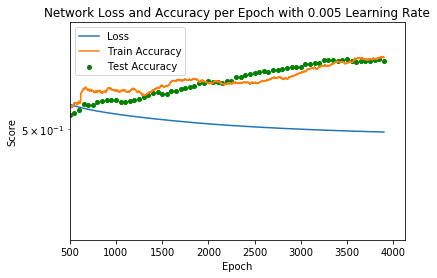

In [67]:
plt.semilogy(losses, label="Loss")
plt.semilogy(train_accuracies, label="Train Accuracy")
plt.scatter(test_num, test_accuracies, label="Test Accuracy", s=16, color="green")
#plt.plot(test_accuracies, label="Test Accuracy")
plt.plot()
plt.legend()
plt.title("Network Loss and Accuracy per Epoch with %1.3f Learning Rate" %learnRate)
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.xlim(500)
plt.ylim(.48, .52)


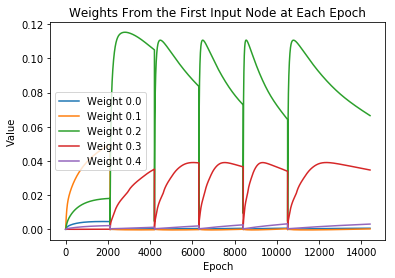

In [57]:

plt.plot((w00s-(w00s[0])), label="Weight 0.0")
plt.plot((w01s-(w01s[0])), label="Weight 0.1")
plt.plot((w02s-(w02s[0])), label="Weight 0.2")
plt.plot((w03s-(w03s[0])), label="Weight 0.3")
plt.plot((w04s-(w04s[0])), label="Weight 0.4")
plt.ylabel("Value")
plt.xlabel("Epoch")
plt.title("Weights From the First Input Node at Each Epoch")
plt.legend()



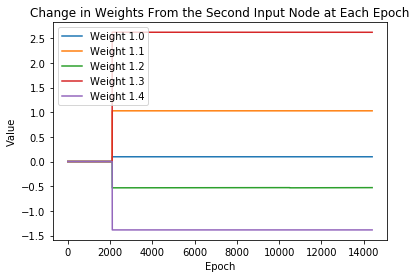

In [58]:

plt.plot((w10s-(w10s[0])), label="Weight 1.0")
plt.plot((w11s-(w11s[0])), label="Weight 1.1")
plt.plot((w12s-(w12s[0])), label="Weight 1.2")
plt.plot((w13s-(w13s[0])), label="Weight 1.3")
plt.plot((w14s-(w14s[0])), label="Weight 1.4")
plt.ylabel("Value")
plt.xlabel("Epoch")
plt.title("Change in Weights From the Second Input Node at Each Epoch")
plt.legend()


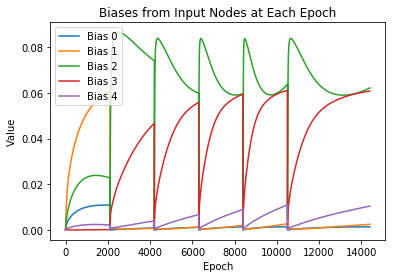

In [59]:

plt.plot(b0s, label="Bias 0")
plt.plot(b1s, label="Bias 1")
plt.plot(b2s, label="Bias 2")
plt.plot(b3s, label="Bias 3")
plt.plot(b4s, label="Bias 4")
plt.ylabel("Value")
plt.xlabel("Epoch")
plt.title("Biases from Input Nodes at Each Epoch")
plt.legend()


In [54]:
W1, b1, W2, b2,b3,W3 = model['W1'], model['b1'], model['W2'], model['b2'],model['b3'],model["W3"]
print("Weight 1: \n", W1)
print("Weight 2: \n", W2)
print("Weight 3: \n", W3)
print("Bias 1: \n", b1)
print("Bias 2: \n", b2)
print("Bias 3: \n", b3)

Weight 1: 
 [[ 2.528742   -0.19908011  1.0217582   3.51568653  2.73830773 -2.92671367
   0.9134001  -1.30679631]
 [-1.20647272 -0.17878132 -0.70798118  1.90780316  0.52215049 -0.75590625
  -0.11223271 -0.33216428]
 [ 1.98803981 -1.41002428 -0.35047391 -2.70224205 -6.10503113  0.31740869
   0.72434178 -2.47991149]
 [ 3.53995039 -3.90764887 -0.75695537 -1.29090832  2.07116008  1.99635018
  -0.71896118 -0.22201675]]
Weight 2: 
 [[-2.77685032 -4.96656971 -1.70470057 -0.68876201  1.45870475  1.42324112
  -1.80294153 -1.60007079]
 [-3.09569032 -3.83503117 -4.40366572  2.90301041 -2.0163604  -1.89429356
  -3.47849087  0.55044613]
 [-4.22268916 -1.42667481 -2.78596458 -0.2248203  -2.00523337 -3.37813729
  -1.04187562 -0.14394051]
 [-0.86257864 -0.40008646 -2.27197773 -1.72592323 -2.30249466 -1.71738239
  -2.6331773  -4.4562493 ]
 [-0.64569863 -1.8085335  -4.26927124 -0.07589593 -2.81466032 -0.87732048
   0.42910608 -0.73750252]
 [ 1.27437715 -3.46479701 -0.20647024 -2.36959838 -2.77362141 -2.1

Text(0.5, 1.0, 'Output node 2 vs Output node 1')

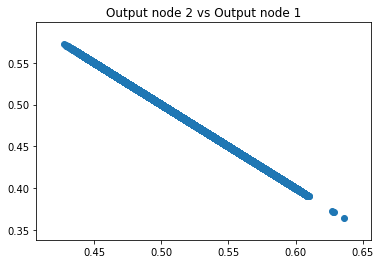

In [49]:
# plot of output node 2 vs output node 1
# get weights and biases
W1, b1, W2, b2,b3,W3 = model['W1'], model['b1'], model['W2'], model['b2'],model['b3'],model["W3"]

diffArray = []

plotX = []
plotY = []

inputArr = []
outputArr = []
for i in range(len(test_data)-1):
    _a0 = test_data[i]
    diffArray.append(_a0[1]-_a0[0])
    inputArr.append(_a0[1])
    _z1 = _a0.dot(W1) + b1
    # Put it through the first activation function
    _a1 = np.tanh(_z1)
    # Second linear step
    _z2 = _a1.dot(W2) + b2
    # Second activation function
    _a2 = np.tanh(_z2)
    #Third linear step
    _z3 = _a2.dot(W3) + b3
    #For the Third linear activation function we use the softmax function, either the sigmoid of softmax should be used for the last layer
    _a3 = softmax(_z3)
    plotX.append(_a3[0][0])
    plotY.append(_a3[0][1])
plt.scatter(plotX, plotY)
plt.title("Output node 2 vs Output node 1")

    # Calculate the point density
#     xy = np.vstack([plotX,plotY])
#     z = gaussian_kde(xy)(xy)

#     fig, ax = plt.subplots()
#     ax.scatter(x, y, c=z, s=100, edgecolor='')
#     plt.show()

#plt.hist(diffArray, bins=500)


0 differences greater than .75


Text(0.5, 1.0, 'Difference in Electron and Muon Output Node Values (E-M)')

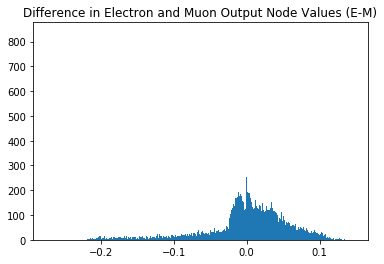

In [50]:
diffArr = []
discardedVals = 0
for x, y in zip(plotX, plotY):
    if(abs(y-x)<.75):
        diffArr.append(y-x)
    else:
        discardedVals += 1
print(discardedVals, "differences greater than .75")
plt.hist(diffArr, bins=1000)
plt.title("Difference in Electron and Muon Output Node Values (E-M)")